In [1]:
!python -V

Python 3.9.16


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pickle
import mlflow

In [3]:
!mkdir data
!mkdir models

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists


# Strart mlflow UI

In [4]:
import subprocess
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///data/mlflow.db"]) 

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'sqli...>

[2023-05-27 04:36:19 +0000] [2744] [INFO] Starting gunicorn 20.1.0
[2023-05-27 04:36:19 +0000] [2744] [INFO] Listening at: http://127.0.0.1:5000 (2744)
[2023-05-27 04:36:19 +0000] [2744] [INFO] Using worker: sync
[2023-05-27 04:36:19 +0000] [2745] [INFO] Booting worker with pid: 2745
[2023-05-27 04:36:19 +0000] [2746] [INFO] Booting worker with pid: 2746
[2023-05-27 04:36:19 +0000] [2747] [INFO] Booting worker with pid: 2747
[2023-05-27 04:36:19 +0000] [2748] [INFO] Booting worker with pid: 2748


In [5]:
mlflow.set_tracking_uri("sqlite:///data/mlflow.db")
# mlflow will create an experiment if it doesn't exist
mlflow.set_experiment("duration-prediction-experiment")

<Experiment: artifact_location='/workspaces/codespaces-blank/mlruns/1', creation_time=1684734875730, experiment_id='1', last_update_time=1684734875730, lifecycle_stage='active', name='duration-prediction-experiment', tags={}>

In [5]:
%%capture
!wget -nc https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet -P data
!wget -nc https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet -P data

In [8]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >=1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype('str')
    return df

In [9]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

/tmp/ipykernel_1027/3707418482.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train["duration"])


<Axes: xlabel='duration', ylabel='Density'>

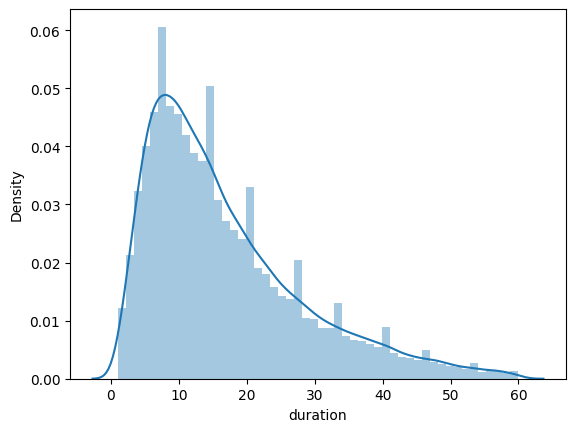

In [9]:
sns.distplot(df_train["duration"])

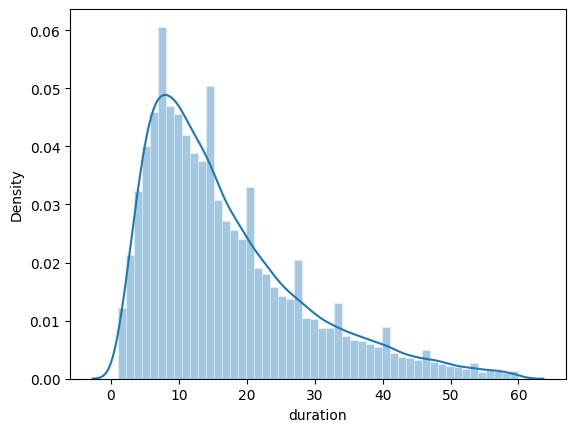

In [10]:
sns.histplot(
    df_train["duration"] , kde=True,
    stat="density", kde_kws=dict(cut=3), bins=50,
    alpha=.4, edgecolor=(1, 1, 1, 0.4),
);

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [11]:
categorical = ['PU_DO']
numerical = ['trip_distance'] 

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
def plot_prediction_vs_actual_distribution(y_true, y_pred):
    sns.histplot(
        y_pred , kde=True,
        stat="density", kde_kws=dict(cut=3), bins=50,
        label='prediction'
    )
    sns.histplot(
        y_true , kde=True,
        stat="density", kde_kws=dict(cut=3), bins=50,
        label='actual'
    )
    plt.legend()

In [15]:
def predict_and_plot(lr):
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    print('RMSE = ', mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False))
    plot_prediction_vs_actual_distribution(y_true=y_val, y_pred=y_pred)
    return lr

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.758715209766874

In [18]:
with mlflow.start_run():
    mlflow.set_tag("developer", "alex")

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', 'data/green_tripdata_2021-02.parquet')
    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')


In [6]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, y_val)

In [24]:

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[10:56:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:11.82045                          
[1]	validation-rmse:8.37527                           
[2]	validation-rmse:7.26555                           
[3]	validation-rmse:6.91154                           
[4]	validation-rmse:6.78081                           
[5]	validation-rmse:6.73657                           
[6]	validation-rmse:6.71418                           
[7]	validation-rmse:6.70237                           
[8]	validation-rmse:6.69553                           
[9]	validation-rmse:6.68874                           
[10]	validation-rmse:6.68052                          
[11]	validation-rmse:6.67566                          
[12]	validation-rmse:6.67259                          
[13]	validation-rmse:6.67194                          
[14]	validation-rmse:6.66895                          
[15]	validation-rmse:6.66341                          
[

In [15]:
params = {
    "learning_rate": 0.2517722152775871,
    "max_depth": 19,
    "min_child_weight": 1.5837833620876487,
    "objective": "reg:linear",
    "reg_alpha": 0.21092711837772837,
    "reg_lambda": 0.12286661143354889,
    "seed": 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)


2023/05/27 05:10:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86a0586dc09945b695ec20dcb8645104', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[05:10:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.75117
[1]	validation-rmse:13.55964
[2]	validation-rmse:11.30594
[3]	validation-rmse:9.75053
[4]	validation-rmse:8.69132
[5]	validation-rmse:7.98772
[6]	validation-rmse:7.52357
[7]	validation-rmse:7.21812
[8]	validation-rmse:7.01236
[9]	validation-rmse:6.87385
[10]	validation-rmse:6.77855
[11]	validation-rmse:6.71314
[12]	validation-rmse:6.66240
[13]	validation-rmse:6.62971
[14]	validation-rmse:6.60513
[15]	validation-rmse:6.58696
[16]	validation-rmse:6.57471
[17]	validation-rmse:6.56501
[18]	validation-rmse:6.55964
[19]	validation-rmse:6.55443
[20]	validation-rmse:6.54905
[21]	validation-rmse:6.54507
[22]	validation-rmse:6.54008
[23]	validation-rmse:6.53677
[24]	validation-rmse:6.53380
[25]	validation-rmse:6.53122
[26]	validation-rmse:6.52615
[27]	validation-rmse:6.52320
[28]	validation-rmse:6.52138
[29]	validation-rmse:6.52007
[30]	validation-rm

2023/05/27 05:12:06 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2023/05/27 05:12:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/.local/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [ ]:
with mlflow.start_run():
    params = {
    "learning_rate": 0.2517722152775871,
    "max_depth": 19,
    "min_child_weight": 1.5837833620876487,
    "objective": "reg:linear",
    "reg_alpha": 0.21092711837772837,
    "reg_lambda": 0.12286661143354889,
    "seed": 42
    }

    mlflow.log_params()

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )